In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import sqlite3

In [70]:
data = pd.read_csv("dailyActivity_merged.csv")
data.head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [71]:
#Feature Engineering
#Changing ActivityDate Column
data["ActivityDate"] = pd.to_datetime(data["ActivityDate"],
                                      format="%m/%d/%Y")
#Total active minutes
data["TotalActiveMinutes"] = (
    data["VeryActiveMinutes"] +
    data["FairlyActiveMinutes"] +
    data["LightlyActiveMinutes"])

#Sedentary percentage
data["SedentaryPct"] = data["SedentaryMinutes"] / (
    data["SedentaryMinutes"] + data["TotalActiveMinutes"])

#Calories per step (efficiency)
data["CaloriesPerStep"] = data["Calories"] / data["TotalSteps"]
data["CaloriesPerStep"].replace([np.inf, -np.inf], np.nan, inplace=True)

#Intensity index
data["IntensityIndex"] = data["VeryActiveMinutes"] / data["TotalActiveMinutes"]

/tmp/ipython-input-1203145646.py:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [72]:
#User Level Aggregation
user_df = data.groupby("Id").agg({
    "TotalSteps": "mean",
    "Calories": "mean",
    "SedentaryMinutes": "mean",
    "TotalActiveMinutes": "mean",
    "IntensityIndex": "mean",
    "SedentaryPct": "mean"}).reset_index()
user_df.head()

,Id,TotalSteps,Calories,SedentaryMinutes,TotalActiveMinutes,IntensityIndex,SedentaryPct
0,1503960366,12116.741935,1816.419355,848.161290,277.806452,0.140755,0.746203
1,1624580081,5743.903226,1483.354839,1257.741935,167.967742,0.027305,0.882291
2,1644430081,7282.966667,2811.300000,1161.866667,209.400000,0.039600,0.847343
3,1844505072,2580.064516,1573.483871,1206.612903,116.870968,0.000751,0.899933
4,1927972279,916.129032,2172.806452,1317.419355,40.677419,0.040169,0.968863


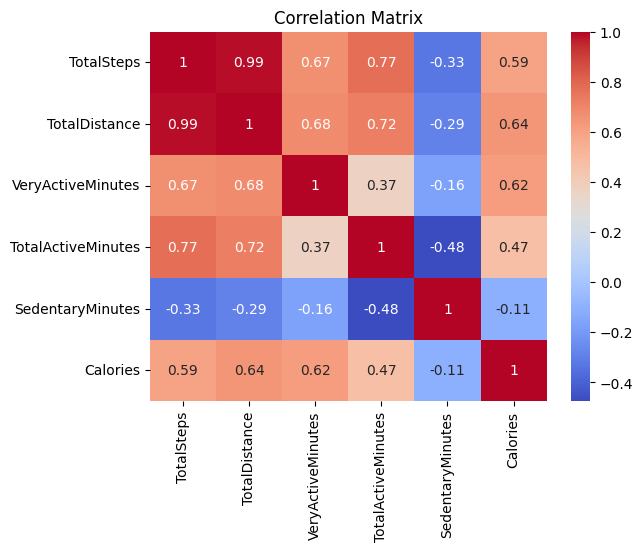

In [73]:
#Correlation Analysis
corr_cols = [
    "TotalSteps",
    "TotalDistance",
    "VeryActiveMinutes",
    "TotalActiveMinutes",
    "SedentaryMinutes",
    "Calories"]

corr = data[corr_cols].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

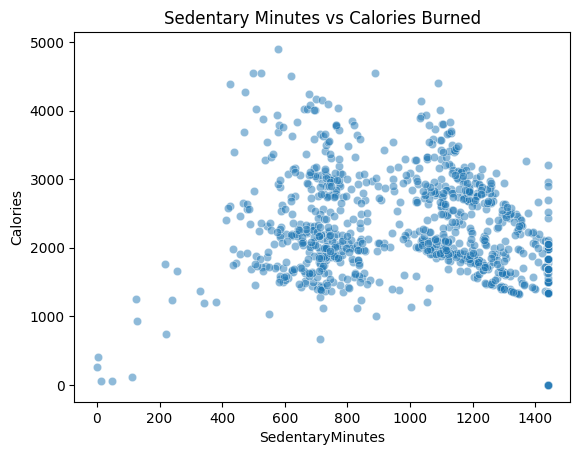

In [74]:
#Sedentary Risk Analysis
sns.scatterplot(
    data=data,
    x="SedentaryMinutes",
    y="Calories",
    alpha=0.5)
plt.title("Sedentary Minutes vs Calories Burned")
plt.show()

In [75]:
#Weekday vs Weekend Analysis
data["DayType"] = data["ActivityDate"].dt.dayofweek.apply(
    lambda x: "Weekend" if x >= 5 else "Weekday")

weekday_stats = data.groupby("DayType")[[
    "TotalSteps",
    "Calories",
    "SedentaryMinutes"]].mean()
weekday_stats

,TotalSteps,Calories,SedentaryMinutes
DayType,,,
Weekday,7668.699281,2301.516547,996.181295
Weekend,7550.571429,2309.546939,977.110204


In [76]:
#User Segmentation
def classify_user(row):
    if row["SedentaryPct"] > 0.75:
        return "Sedentary Dominant"
    elif row["IntensityIndex"] > 0.4:
        return "High Intensity"
    elif row["TotalSteps"] > 10000:
        return "Active Walker"
    else:
        return "Light Activity"

user_df["UserType"] = user_df.apply(classify_user, axis=1)

user_df["UserType"].value_counts()

,count
UserType,
Sedentary Dominant,22
Light Activity,8
Active Walker,3


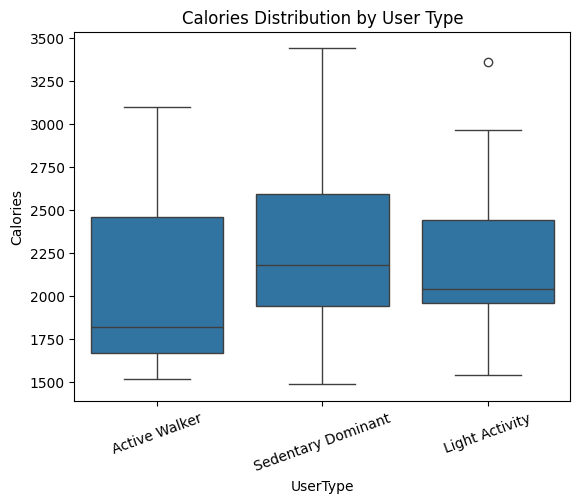

In [77]:
#Visualizing User Types
sns.boxplot(
    data=user_df,
    x="UserType",
    y="Calories")
plt.xticks(rotation=20)
plt.title("Calories Distribution by User Type")
plt.show()

In [101]:
#Relationship between Calories & Total Steps
figure = px.scatter(data_frame = data, x="Calories",
                    y="TotalSteps", size="VeryActiveMinutes",
                    trendline="ols",
                    title="Relationship between Calories & Total Steps")
figure.update_layout(width=700, height=450)
figure.show()

In [102]:
#Total Active Minutes
label = ["Very Active Minutes", "Fairly Active Minutes",
         "Lightly Active Minutes", "Inactive Minutes"]
counts = data[["VeryActiveMinutes", "FairlyActiveMinutes",
               "LightlyActiveMinutes", "SedentaryMinutes"]].mean()
colors = ['green','red', "yellow", "blue"]

fig = go.Figure(data=[go.Pie(labels=label, values=counts)])
fig.update_layout(title_text='Total Active Minutes')
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=30,
                  marker=dict(colors=colors, line=dict(color='black', width=3)))
fig.update_layout(width=700, height=450)
fig.show()

In [103]:
#Extract weekday name from ActivityDate column
data["Day"] = data["ActivityDate"].dt.day_name()
print(data["Day"].head())

0      Tuesday
1    Wednesday
2     Thursday
3       Friday
4     Saturday
Name: Day, dtype: object


In [106]:
#Grouped bar chart of activity intensity by weekday
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data["Day"],
    y=data["VeryActiveMinutes"],
    name='Very Active',
    marker_color='green'))
fig.add_trace(go.Bar(
    x=data["Day"],
    y=data["FairlyActiveMinutes"],
    name='Fairly Active',
    marker_color='red'))
fig.add_trace(go.Bar(
    x=data["Day"],
    y=data["LightlyActiveMinutes"],
    name='Lightly Active',
    marker_color='blue'))
fig.update_layout(barmode='group', xaxis_tickangle=-45)
fig.update_layout(width=700, height=450)
fig.show()

In [118]:
#Pie chart of total sedentary minutes by weekday
day = data["Day"].value_counts()
label = day.index
counts = data["SedentaryMinutes"]
colors = ['#4e79a7','#f28e2b','#59a14f','#e15759','#af7aa1','#9c755f','#edc949']

fig = go.Figure(data=[go.Pie(labels=label, values=counts)])
fig.update_layout(title_text='Inactive Minutes Daily')
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=30,
                  marker=dict(colors=colors, line=dict(color='black', width=3)))
fig.update_layout(width=700, height=450)
fig.show()

In [117]:
#Pie chart of total calories burned by weekday
calories = data["Day"].value_counts()
label = calories.index
counts = data["Calories"]
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2']

fig = go.Figure(data=[go.Pie(labels=label, values=counts)])
fig.update_layout(title_text='Calories Burned Daily')
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=30,
                  marker=dict(colors=colors, line=dict(color='black', width=3)))
fig.update_layout(width=700, height=450)
fig.show()

In [84]:
#Product Usage Insight
(data["LoggedActivitiesDistance"] > 0).mean()

np.float64(0.03404255319148936)

In [85]:
#Creating in memory SQLite DB
conn = sqlite3.connect(":memory:")

#Push dataframe into SQL
data.to_sql("activity", conn, index=False, if_exists="replace")

940

In [86]:
#Top 5 Most Active Users (by avg steps)
query = """SELECT
    Id,
    ROUND(AVG(TotalSteps), 2) AS avg_steps
FROM activity
GROUP BY Id
ORDER BY avg_steps DESC
LIMIT 5;"""

pd.read_sql(query, conn)

,Id,avg_steps
0,8877689391,16040.03
1,8053475328,14763.29
2,1503960366,12116.74
3,2022484408,11370.65
4,7007744171,11323.42


In [87]:
#Calories vs Activity Intensity (Truth Test)
#Does intensity matter more than steps?
query = """SELECT
    ROUND(AVG(VeryActiveMinutes), 2) AS avg_very_active_min,
    ROUND(AVG(Calories), 2) AS avg_calories
FROM activity
WHERE TotalSteps > 10000;"""

pd.read_sql(query, conn)

,avg_very_active_min,avg_calories
0,48.54,2743.58


In [88]:
#Calories vs Activity Intensity (Truth Test)
#Compare with low-step users:
query = """SELECT
    ROUND(AVG(VeryActiveMinutes), 2) AS avg_very_active_min,
    ROUND(AVG(Calories), 2) AS avg_calories
FROM activity
WHERE TotalSteps < 5000;"""

pd.read_sql(query, conn)
#Conclusion: Steps alone ≠ calorie burn. intensity beats quantity.

,avg_very_active_min,avg_calories
0,2.34,1806.81


In [89]:
#Sedentary Time Distribution
query = """SELECT
    CASE
        WHEN SedentaryMinutes > 1000 THEN 'Extreme Sedentary'
        WHEN SedentaryMinutes BETWEEN 700 AND 1000 THEN 'High Sedentary'
        ELSE 'Moderate/Low'
    END AS sedentary_level,
    COUNT(*) AS days_count
FROM activity
GROUP BY sedentary_level;"""

pd.read_sql(query, conn)
#Insight:Majority days fall in high sedentary bucket.

,sedentary_level,days_count
0,Extreme Sedentary,515
1,High Sedentary,247
2,Moderate/Low,178


In [90]:
#Weekday vs Weekend Behavior
query = """SELECT
    CASE
        WHEN strftime('%w', ActivityDate) IN ('0','6') THEN 'Weekend'
        ELSE 'Weekday'
    END AS day_type,
    ROUND(AVG(TotalSteps), 2) AS avg_steps,
    ROUND(AVG(Calories), 2) AS avg_calories
FROM activity
GROUP BY day_type;"""

pd.read_sql(query, conn)

,day_type,avg_steps,avg_calories
0,Weekday,7668.70,2301.52
1,Weekend,7550.57,2309.55


In [91]:
#Calories per Step Efficiency
query = """SELECT
    Id,
    ROUND(AVG(Calories * 1.0 / NULLIF(TotalSteps, 0)), 4) AS calories_per_step
FROM activity
WHERE TotalSteps > 0
GROUP BY Id
ORDER BY calories_per_step DESC
LIMIT 5;"""

pd.read_sql(query, conn)

,Id,calories_per_step
0,1844505072,26.2182
1,6775888955,12.9382
2,4020332650,11.1788
3,1927972279,3.5528
4,4319703577,2.4314


In [92]:
#Consistency Check
query = """SELECT
    Id,
    MAX(TotalSteps) - MIN(TotalSteps) AS step_range
FROM activity
GROUP BY Id
ORDER BY step_range ASC
LIMIT 5;"""

pd.read_sql(query, conn)

,Id,step_range
0,1927972279,3790
1,4057192912,5974
2,3372868164,6638
3,2873212765,7161
4,1844505072,8054
